<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/Computer%20Vision/Hugging%20Face/0_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

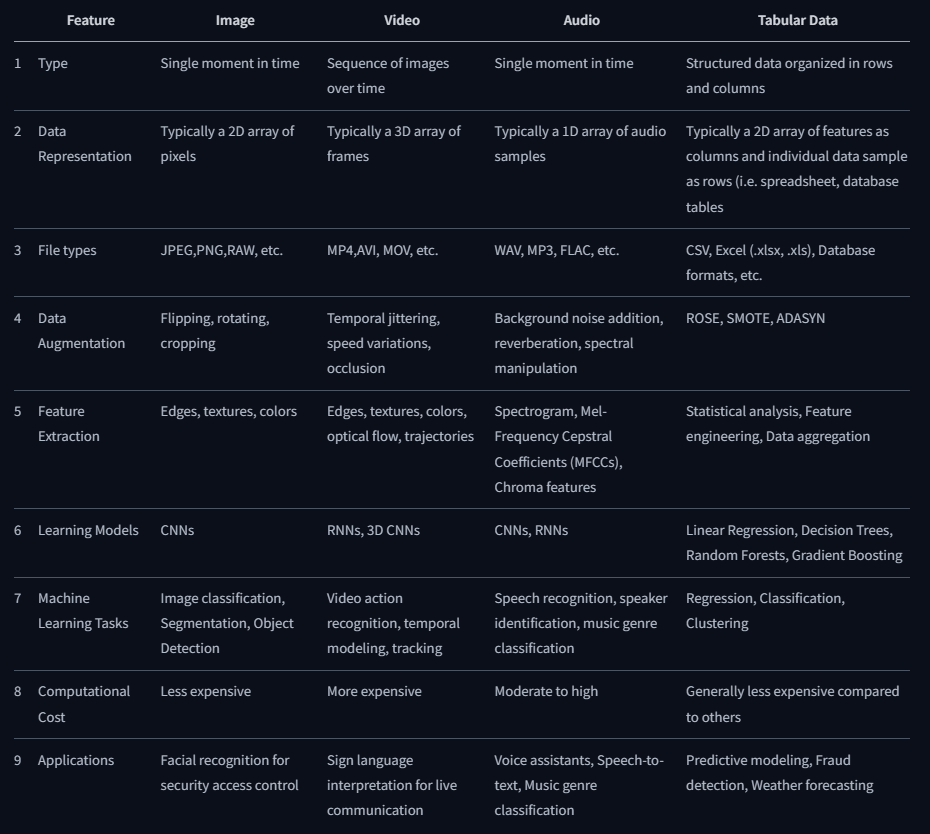

## VGG19 on Pytorch
---
138 million parameters

In [1]:
import torch.nn as nn


class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()

        # Feature extraction layers: Convolutional and pooling layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=3, padding=1
            ),  # 3 input channels, 64 output channels, 3x3 kernel, 1 padding
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Max pooling with 2x2 kernel and stride 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(
                512 * 7 * 7, 4096
            ),  # 512 channels, 7x7 spatial dimensions after max pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 0.5 dropout probability
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Output layer with 'num_classes' output units
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Pass input through the feature extractor layers
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass flattened output through the classifier layers
        return x

## The Inception "Network in Network" Model
---

### 1x1 Convolution:
* The 1x1 convolution learns how to combine the information from different channels for each spatial location. This effectively enables the network to mix and recombine features across different channels.
* The 1x1 convolution acts like a bottleneck that reduces the dimensionality of the input before feeding it into larger convolutional layers.
  * If you have a feature map of size 64×64×512 (64x64 spatial dimensions with 512 channels), applying a 3x3 convolution would require significant computational resources. A 1x1 convolution could first reduce the channels from 512 to, say, 64, reducing the computation load. Then, a 3x3 convolution is applied on this reduced-depth feature map, which is computationally less expensive.
* The 1x1 convolution, combined with non-linear activations (ReLU), enables the network to learn more complex, abstract representations of the input data.
* Since the 1x1 convolution operates on individual spatial locations but across all channels, it's also a form of local feature combination. Each spatial location in the output feature map is a weighted combination of features from all channels at the corresponding spatial location in the input.

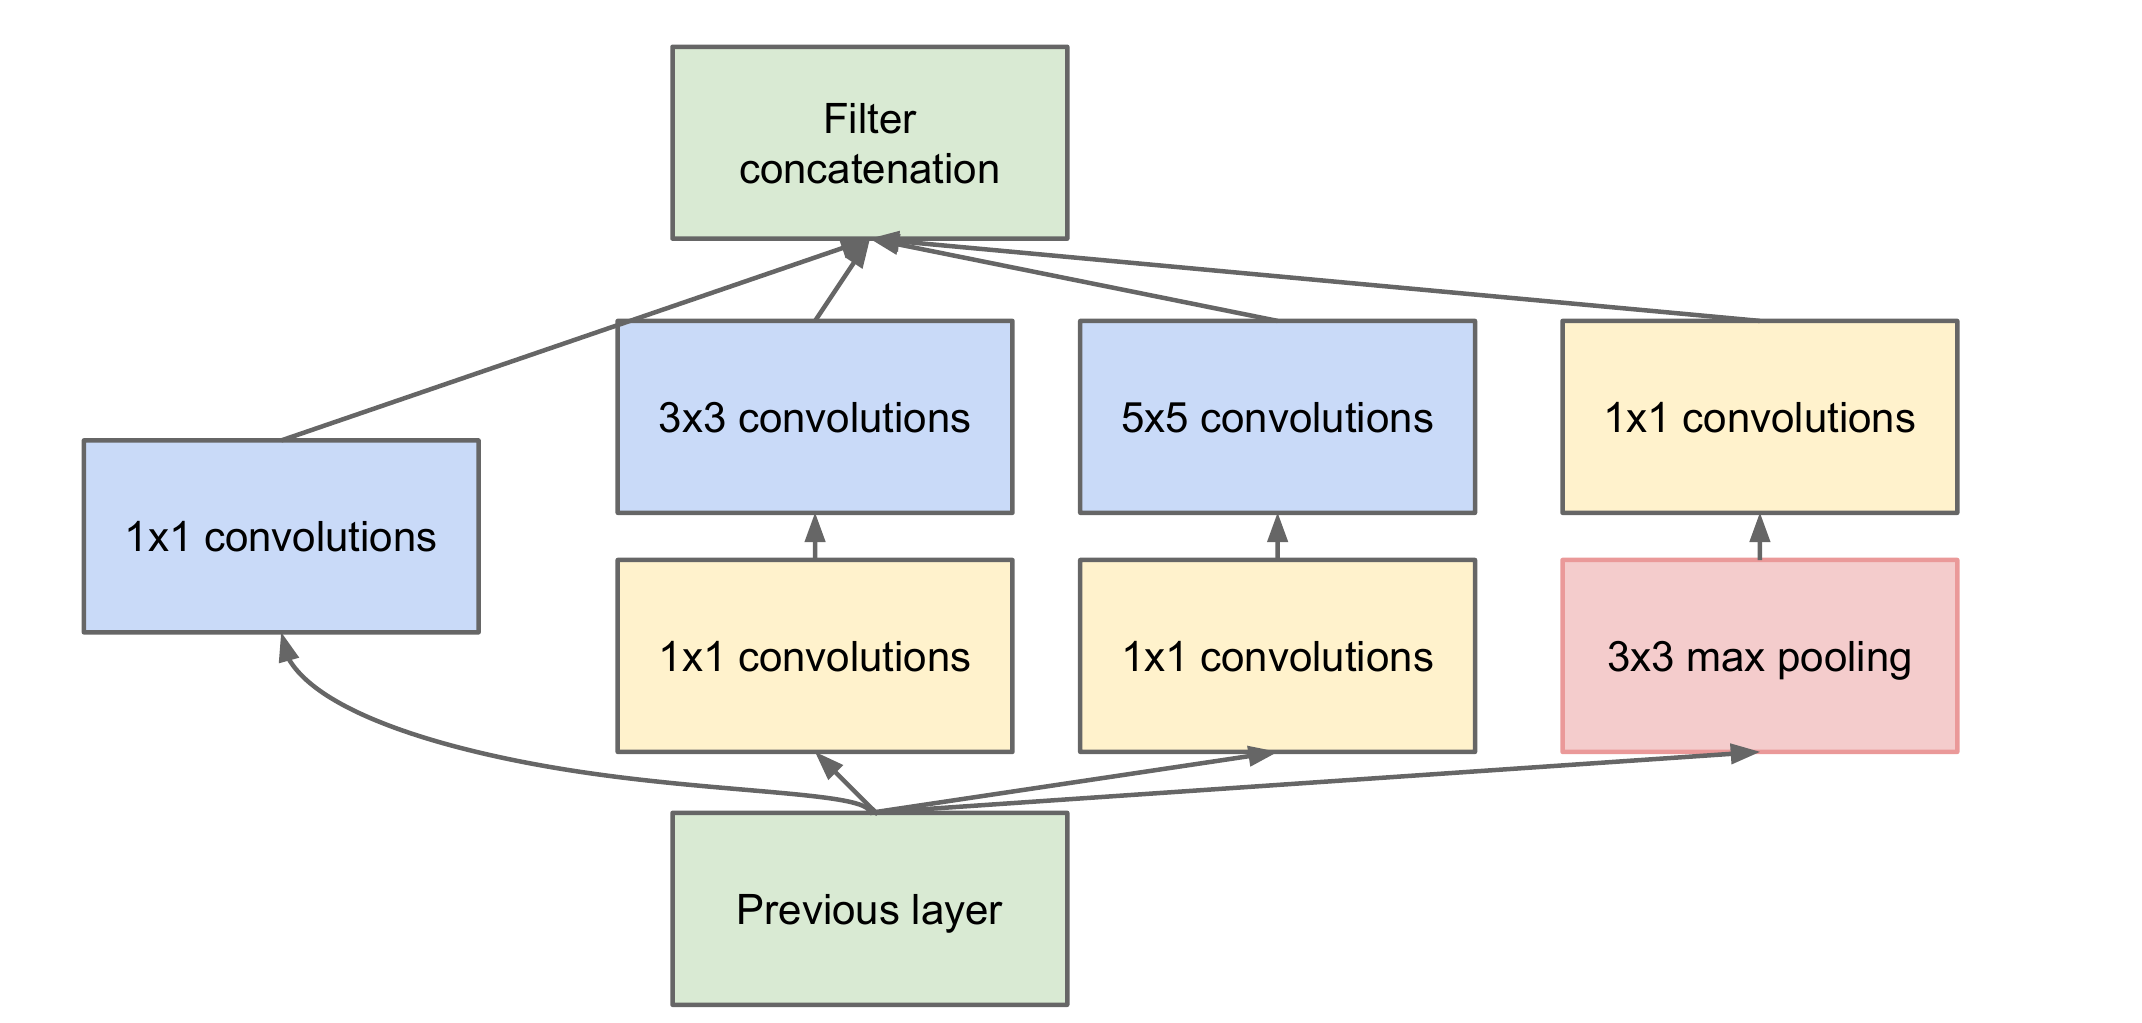

## Auxiliary Classifiers
---
With the introduction of compute saving 1×1 convolution and the replacement of multiple fully connected layers with average pooling, the parameters of this network are reduced significantly, which means we can add more layers and go deeper into the network. However, stacking layers can cause the problem of vanishing gradient, where the gradients get smaller and close to zero while propagating back to the initial layers of the network.

The paper introduces the auxiliary classifiers - branch out a few small classifiers from the layers in between and add the loss from these classifiers to the total loss(with less weightage). This ensures that the layers close to the input also receive gradients of decent magnitude.

The auxiliary classifier consists of:

* An average pooling layer with5×5 filter size and stride 3.
* A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.
* A fully connected layer with 1024 units and rectified linear activation.
* A dropout layer with 70% ratio of dropped outputs.
* A linear layer with softmax loss as the classifier.

## GoogLeNet
---


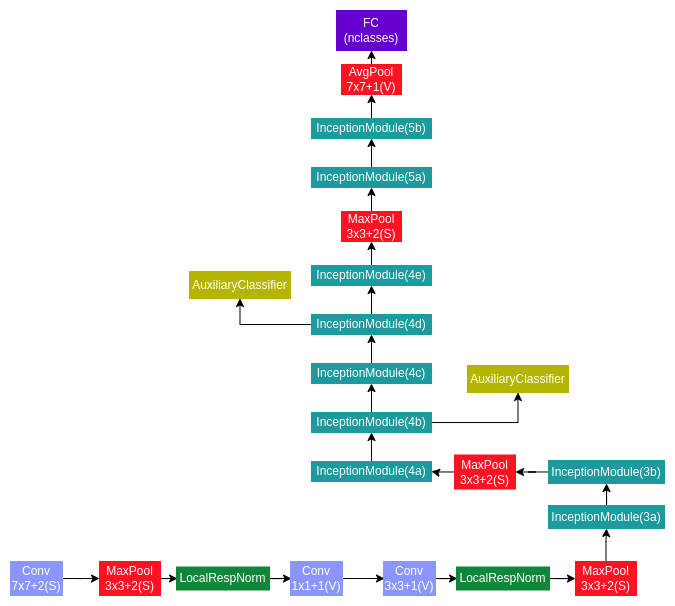

In [2]:
import torch
import torch.nn as nn


class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.b1 = BaseConv2d(in_channels, n1x1, kernel_size=1)

        self.b2 = nn.Sequential(
            BaseConv2d(in_channels, n3x3red, kernel_size=1),
            BaseConv2d(n3x3red, n3x3, kernel_size=3, padding=1),
        )

        self.b3 = nn.Sequential(
            BaseConv2d(in_channels, n5x5red, kernel_size=1),
            BaseConv2d(n5x5red, n5x5, kernel_size=5, padding=2),
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            BaseConv2d(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.7):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AvgPool2d(5, stride=3)
        self.conv = BaseConv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class GoogLeNet(nn.Module):
    def __init__(self, use_aux=True):
        super(GoogLeNet, self).__init__()

        self.use_aux = use_aux
        ## block 1
        self.conv1 = BaseConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 2
        self.conv2 = BaseConv2d(64, 64, kernel_size=1)
        self.conv3 = BaseConv2d(64, 192, kernel_size=3, padding=1)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 3
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 4
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 5
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        ## auxiliary classifier
        if self.use_aux:
            self.aux1 = AuxiliaryClassifier(512, 1000)
            self.aux2 = AuxiliaryClassifier(528, 1000)

        ## block 6
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        ## block 1
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)

        ## block 2
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        ## block 3
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        ## block 4
        x = self.inception4a(x)
        if self.use_aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.use_aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        ## block 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        ## block 6
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.use_aux:
            return x, aux1, aux2
        else:
            return x

## MobileNet
---

Depthwise separable convolutions break down the computation into two separate steps: depthwise convolution followed by pointwise convolution. This results in a significant reduction of parameters and computational complexity, allowing MobileNet to run efficiently on mobile devices.


* Depthwise Convolutions: This step performs a convolution separately for each channel (a single color or feature) in the input image using a small filter (usually 3x3). The output of this step is the same size as the input but with fewer channels.

* Pointwise Convolutions: This type of convolution applies a single filter (usually 1x1) across all channels in both input and output layers. It has fewer parameters than regular convolution and can be seen as an alternative to fully connected layers, making it suitable for mobile devices that have limited computational resources. After depthwise convolution, this step combines the filtered outputs from previous steps using another 1x1 convolutional layer. This operation effectively aggregates the features learned by the depthwise convolutions into a smaller set of features, reducing the overall complexity while retaining important information.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)

        # MobileNet body
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)

        # 5 depthwise separable convolutions with stride 1
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)

        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.dw_conv2(x)
        x = F.relu(x)
        x = self.dw_conv3(x)
        x = F.relu(x)
        x = self.dw_conv4(x)
        x = F.relu(x)
        x = self.dw_conv5(x)
        x = F.relu(x)
        x = self.dw_conv6(x)
        x = F.relu(x)
        x = self.dw_conv7(x)
        x = F.relu(x)

        x = self.dw_conv8(x)
        x = F.relu(x)
        x = self.dw_conv9(x)
        x = F.relu(x)
        x = self.dw_conv10(x)
        x = F.relu(x)
        x = self.dw_conv11(x)
        x = F.relu(x)
        x = self.dw_conv12(x)
        x = F.relu(x)

        x = self.dw_conv13(x)
        x = F.relu(x)
        x = self.dw_conv14(x)
        x = F.relu(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Create the model
mobilenet = MobileNet(num_classes=1000)
print(mobilenet)

## ResNet: Residual Network
---
Neural networks with more layers were assumed to be more effective because adding more layers improves the model performance. However, due to degradation problem, as the neural networks became deeper, accuracy saturated and degraded rapidly. An experiment comparing shallow and deep plain networks revealed that deeper models exhibited higher training and test errors, suggesting a fundamental challenge in training deeper architectures effectively. This degradation was not because of overfitting but because the training error increased when the network became deeper. The added layers did not approximate the identity function.

ResNet’s residual connections unlocked the potential of the extreme depth, propelling the accuracy upwards compared to the previous architectures. ResNet’s building blocks designed as identity functions, preserve input information while enabling learning. This approach ensures efficient weight optimization and prevents degradation as the network becomes deeper.

* Deep Residual Learning for Image Recognition: https://arxiv.org/abs/1512.03385
* HuggingFace ResNet Documentation: https://huggingface.co/docs/transformers/en/model_doc/resnet

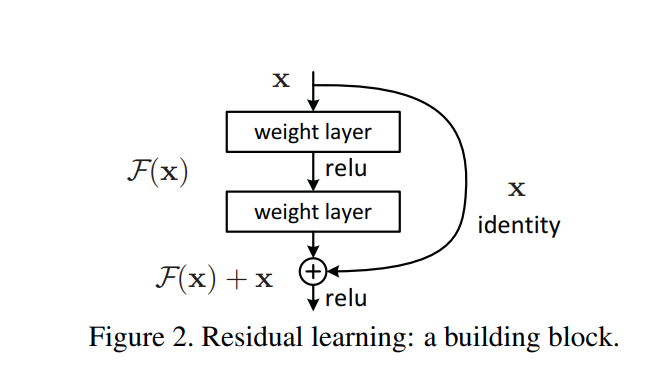

In [ ]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])